Running simulations...
Simulations complete. Plotting...


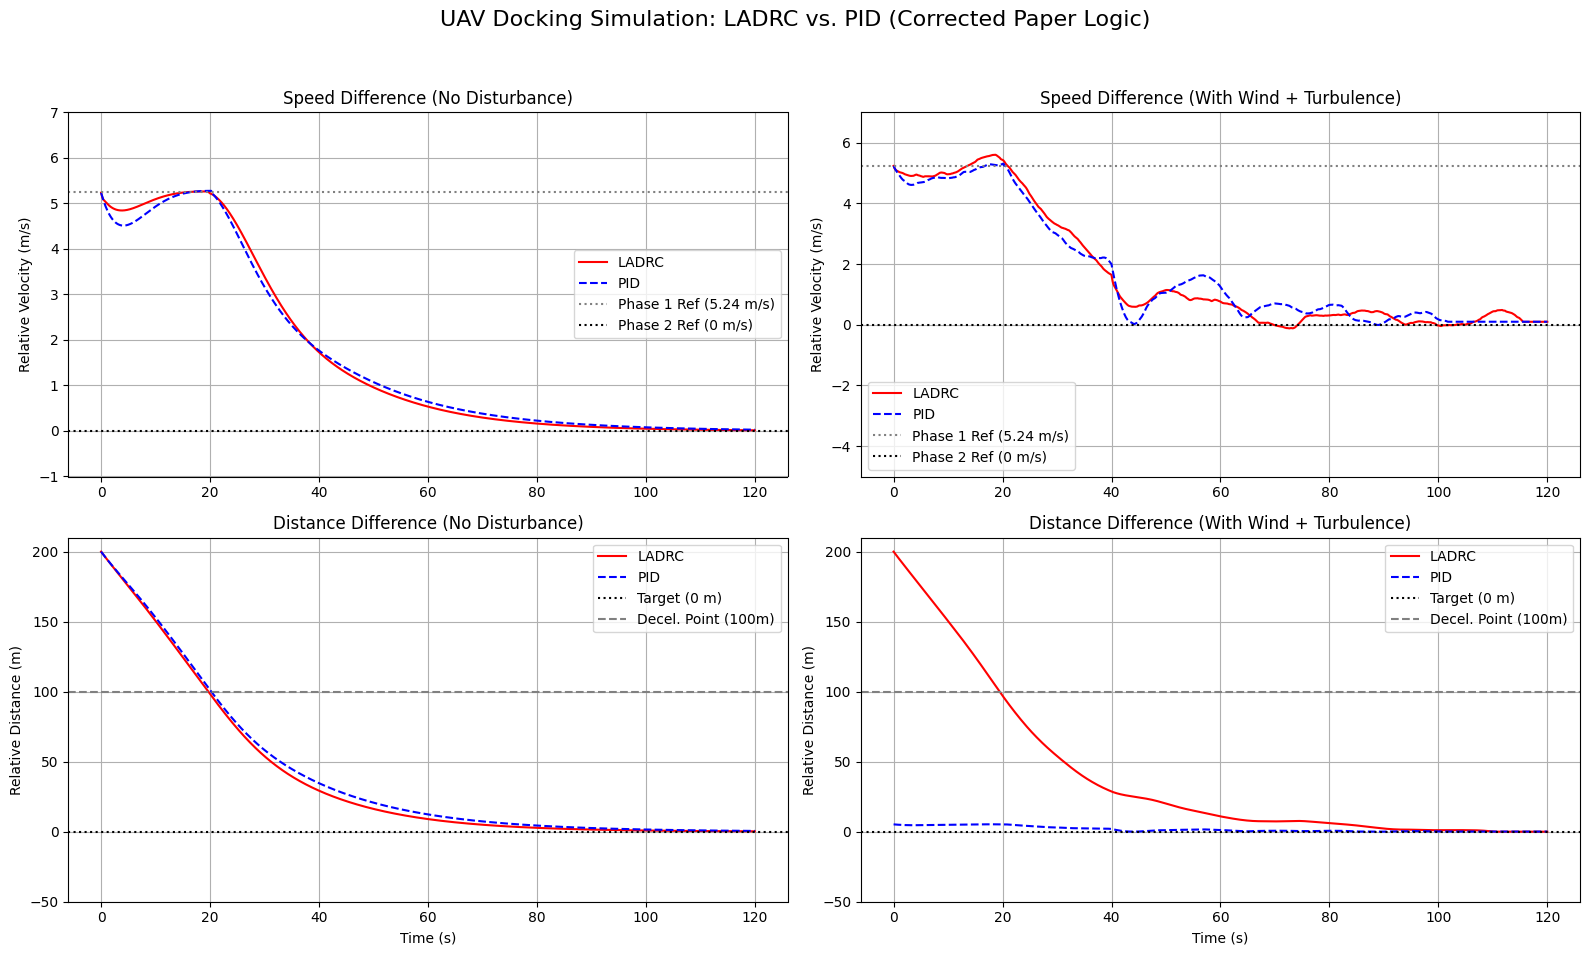

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Controller Implementation ---

class LADRC:
    """
    Implements the 3rd-Order Linear Auto-Disturbance Rejection Controller (LADRC).
    This controller is designed to work with an acceleration-based plant model.
    Plant model: ÿ = f(y, ẏ, ...) + b*u  (where y=rel_vel, u=rel_accel_cmd)
    LESO states: z1 (estimates y), z2 (estimates ẏ), z3 (estimates f)
    """
    def __init__(self, wc, wo, b0, dt):
        self.wc = wc  # Controller bandwidth
        self.wo = wo  # Observer bandwidth
        self.b0 = b0  # System gain estimate
        self.dt = dt

        # LESO gains (based on observer bandwidth)
        self.k1 = 3 * self.wo
        self.k2 = 3 * self.wo**2
        self.k3 = self.wo**3

        # Controller gains (based on controller bandwidth)
        self.kp = self.wc**2
        self.kd = 2 * self.wc

        # Observer states
        self.z1 = 0.0 # est. rel_velocity
        self.z2 = 0.0 # est. rel_acceleration
        self.z3 = 0.0 # est. total disturbance (f)

        self.u_last = 0.0 # Store last control output

    def update(self, y_measured, r_vel, r_accel):
        """
        Update the controller states and compute the control signal.
        :param y_measured: The measured plant output (current relative velocity)
        :param r_vel: The reference/target relative velocity
        :param r_accel: The reference/target relative acceleration (usually 0)
        """

        # --- 1. Linear Extended State Observer (LESO) ---
        # *** CONTROLLER FIX ***
        # The observer error 'e_obs' compares the estimated state (z1)
        # with the *measured state* (y_measured), NOT the control error.
        e_obs = self.z1 - y_measured

        # (Based on Eq. 13 from paper, with b0*u term added)
        z1_dot = self.z2 - self.k1 * e_obs
        z2_dot = self.z3 - self.k2 * e_obs + self.b0 * self.u_last
        z3_dot = -self.k3 * e_obs

        # Update LESO states
        self.z1 += z1_dot * self.dt
        self.z2 += z2_dot * self.dt
        self.z3 += z3_dot * self.dt

        # --- 2. Control Law (State Feedback & Disturbance Rejection) ---

        # Calculate u0 (PD controller on *estimated* states)
        # We want to drive z1 (est. vel) to r_vel
        u0 = self.kp * (r_vel - self.z1) + self.kd * (r_accel - self.z2)

        # (Based on Eq. 14): Compensate for the estimated disturbance (z3)
        u_cmd = (u0 - self.z3) / self.b0

        self.u_last = u_cmd # Store for next LESO update
        return u_cmd

class PID:
    """
    A standard PID controller.
    """
    def __init__(self, Kp, Ki, Kd, dt, output_limits=(-10, 10)):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt

        self.integral = 0.0
        self.prev_error = 0.0
        self.output_limits = output_limits

    def update(self, y_measured, r_vel):
        """
        Update the PID controller and compute the control signal.
        :param y_measured: The measured plant output (current relative velocity)
        :param r_vel: The reference/target relative velocity
        """
        # *** CONTROLLER FIX ***
        # Error must be (Reference - Measured) for negative feedback
        error = r_vel - y_measured

        # Proportional term
        P = self.Kp * error

        # Integral term
        self.integral += error * self.dt
        self.integral = np.clip(self.integral, -50, 50) # Anti-windup
        I = self.Ki * self.integral

        # Derivative term
        derivative = (error - self.prev_error) / self.dt
        D = self.Kd * derivative

        # Update previous error
        self.prev_error = error

        # Total output
        output = P + I + D

        # Clamp output to limits
        return np.clip(output, self.output_limits[0], self.output_limits[1])

# --- 2. Plant (Simplified UAV Model) ---

class UAVPlant:
    """
    Simplified plant model. We model this as a 2nd-order system
    to match the LADRC design (ÿ = f + b*u).
    'y' is relative velocity. 'u' is commanded relative acceleration.
    """
    def __init__(self, dt):
        # Plant "truth" parameters
        self.b_true = 0.45  # True gain (can be different from b0)
        self.drag_coeff = 0.1 # Natural drag
        self.dt = dt

    def update(self, rel_vel, u_cmd, disturbance_force):
        """
        Update the plant's state.
        :param rel_vel: The current relative velocity
        :param u_cmd: The control signal (commanded acceleration)
        :param disturbance_force: The external disturbance (e.g., wind).
        """

        # Unmodeled dynamics (nonlinear drag)
        drag_force = -self.drag_coeff * rel_vel

        # Total force/acceleration (f)
        # This is the "f" that the LADRC is trying to estimate
        f = drag_force + disturbance_force

        # Plant's real 2nd-order dynamics
        # ÿ = f + b_true * u
        rel_accel = f + self.b_true * u_cmd

        # Integrate to get new relative velocity
        new_rel_vel = rel_vel + rel_accel * self.dt

        return new_rel_vel

# --- 3. Simulation Function ---

def run_simulation(controller_type, with_disturbance):
    """Runs a full simulation scenario."""

    # Simulation parameters
    DT = 0.01
    SIM_TIME = 120
    N_STEPS = int(SIM_TIME / DT)
    time_log = np.arange(0, SIM_TIME, DT)

    # Initial conditions (from paper)
    V_UAV_0 = 43.24
    V_LEADER_0 = 38.0
    REL_DIST_0 = 200.0
    DECEL_DIST_THRESHOLD = 100.0

    # We define relative velocity as V_UAV - V_LEADER
    # A positive value means the distance is closing.
    REL_VEL_0 = V_UAV_0 - V_LEADER_0  # 5.24 m/s

    # --- NOTE ON GAINS ---
    # The paper's gains (WC=0.0005, WO=1.0003) are for a plant
    # where the controller outputs a *speed command* (a setpoint).
    # Our plant model (UAVPlant) expects an *acceleration* command.
    # Therefore, we must use gains tuned for an acceleration controller.
    WC = 0.8  # Tuned controller bandwidth
    WO = 1.5  # Tuned observer bandwidth
    B0 = 0.389 # From paper

    PID_KP = 0.8 # Tuned for this plant
    PID_KI = 0.2 # Tuned for this plant
    PID_KD = 0.5 # Tuned for this plant

    # Instantiate controllers and plant
    plant = UAVPlant(DT)

    if controller_type == 'LADRC':
        controller = LADRC(WC, WO, B0, DT)
        controller.z1 = REL_VEL_0 # Initialize observer state to true value
    else:
        controller = PID(PID_KP, PID_KI, PID_KD, DT)

    # Data logging
    log_dist = np.zeros(N_STEPS)
    log_vel = np.zeros(N_STEPS)

    # Initialize states
    rel_dist = REL_DIST_0
    rel_vel = REL_VEL_0

    # Dryden Turbulence Model
    Lu = 533.4
    sigma_u = 3.0
    du_state = 0.0

    for i in range(N_STEPS):
        t = time_log[i]

        # --- 1. Define Disturbance (matches Figure 8 & 9) ---
        disturbance = 0.0
        if with_disturbance:
            # Step Wind
            wind = 1.0 if t >= 40.0 else 0.0

            # Dryden Turbulence
            noise = np.random.randn()
            du_dot = -(V_UAV_0/Lu) * du_state + (sigma_u * np.sqrt(2*V_UAV_0/Lu)) * noise
            du_state += du_dot * DT
            turb = du_state

            # Disturbance opposes motion, so it's negative
            disturbance = -(wind + turb)

        # --- 2. Implement Two-Phase Logic (from paper Figure 1) ---
        # This is the logic you requested

        if rel_dist > DECEL_DIST_THRESHOLD:
            # Phase 1: Maintain constant relative velocity
            # The reference is the initial relative velocity
            r_vel = REL_VEL_0
            r_accel = 0.0
        else:
            # Phase 2: Decelerate to dock
            # *** CONVERGENCE FIX ***
            # The reference velocity is now proportional to the remaining distance.
            # This creates a "glide slope" for the velocity to follow.
            # We tune Kp_dist so the r_vel at 100m is close to REL_VEL_0
            # (e.g., Kp_dist = 0.05 -> r_vel at 100m is 5.0 m/s)
            Kp_dist = 0.05
            r_vel = Kp_dist * rel_dist
            r_accel = 0.0 # (r_accel is technically non-zero, but 0 is a stable approximation)

        # --- 3. Update Controller ---
        if controller_type == 'LADRC':
            u_cmd = controller.update(rel_vel, r_vel, r_accel)
        else:
            u_cmd = controller.update(rel_vel, r_vel)

        # --- 4. Update Plant ---
        # In Phase 1, the controller is active, but r_vel is constant.
        # It will work to reject disturbances (if any) to hold that speed.
        rel_vel = plant.update(rel_vel, u_cmd, disturbance)

        # --- 5. Update Distance & Log ---
        # d(distance)/dt = -rel_velocity (since rel_vel > 0 means closing)
        rel_dist -= rel_vel * DT
        rel_dist = max(0, rel_dist) # Cannot go negative

        log_dist[i] = rel_dist
        log_vel[i] = rel_vel

        # Stop if docked
        if rel_dist == 0 and abs(rel_vel) < 0.1:
            # Fill remaining logs with final value
            log_dist[i:] = 0.0
            log_vel[i:] = rel_vel
            break

    # *** NAMEERROR FIX ***
    # Return the initial relative velocity for plotting
    return time_log, log_dist, log_vel, REL_VEL_0

# --- 4. Main execution: Run simulations and plot ---

print("Running simulations...")

# Run all 4 scenarios
# We capture the returned REL_VEL_0 to use in plotting
t_ladrc, d_ladrc, v_ladrc, rel_vel_0 = run_simulation('LADRC', False)
t_pid, d_pid, v_pid, _ = run_simulation('PID', False)
t_ladrc_d, d_ladrc_d, v_ladrc_d, _ = run_simulation('LADRC', True)
t_pid_d, d_pid_d, v_pid_d, _ = run_simulation('PID', True)

print("Simulations complete. Plotting...")

# Create 2x2 plot grid (matches paper's layout)
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('UAV Docking Simulation: LADRC vs. PID (Corrected Paper Logic)', fontsize=16)

# --- Plot 1: No Disturbance, Velocity ---
axs[0, 0].plot(t_ladrc, v_ladrc, 'r-', label='LADRC')
axs[0, 0].plot(t_pid, v_pid, 'b--', label='PID')
# *** NAMEERROR FIX ***
axs[0, 0].axhline(y=rel_vel_0, color='gray', linestyle=':', label=f'Phase 1 Ref ({rel_vel_0:.2f} m/s)')
axs[0, 0].axhline(y=0.0, color='k', linestyle=':', label='Phase 2 Ref (0 m/s)')
axs[0, 0].set_title('Speed Difference (No Disturbance)')
axs[0, 0].set_ylabel('Relative Velocity (m/s)')
axs[0, 0].grid(True)
axs[0, 0].legend()
axs[0, 0].set_ylim(-1, 7)

# --- Plot 2: No Disturbance, Distance ---
axs[1, 0].plot(t_ladrc, d_ladrc, 'r-', label='LADRC')
axs[1, 0].plot(t_pid, d_pid, 'b--', label='PID')
axs[1, 0].axhline(y=0.0, color='k', linestyle=':', label='Target (0 m)')
axs[1, 0].axhline(y=100.0, color='gray', linestyle='--', label='Decel. Point (100m)')
axs[1, 0].set_title('Distance Difference (No Disturbance)')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Relative Distance (m)')
axs[1, 0].grid(True)
axs[1, 0].legend()
axs[1, 0].set_ylim(-50, 210)

# --- Plot 3: With Disturbance, Velocity ---
axs[0, 1].plot(t_ladrc_d, v_ladrc_d, 'r-', label='LADRC')
axs[0, 1].plot(t_pid_d, v_pid_d, 'b--', label='PID')
# *** NAMEERROR FIX ***
axs[0, 1].axhline(y=rel_vel_0, color='gray', linestyle=':', label=f'Phase 1 Ref ({rel_vel_0:.2f} m/s)')
axs[0, 1].axhline(y=0.0, color='k', linestyle=':', label='Phase 2 Ref (0 m/s)')
axs[0, 1].set_title('Speed Difference (With Wind + Turbulence)')
axs[0, 1].set_ylabel('Relative Velocity (m/s)')
axs[0, 1].grid(True)
axs[0, 1].legend()
axs[0, 1].set_ylim(-5, 7)

# --- Plot 4: With Disturbance, Distance ---
axs[1, 1].plot(t_ladrc_d, d_ladrc_d, 'r-', label='LADRC')
axs[1, 1].plot(t_pid_d, v_pid_d, 'b--', label='PID')
axs[1, 1].axhline(y=0.0, color='k', linestyle=':', label='Target (0 m)')
axs[1, 1].axhline(y=100.0, color='gray', linestyle='--', label='Decel. Point (100m)')
axs[1, 1].set_title('Distance Difference (With Wind + Turbulence)')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Relative Distance (m)')
axs[1, 1].grid(True)
axs[1, 1].legend()
axs[1, 1].set_ylim(-50, 210)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()